# WiDS (WGAN-GPs)


In [ ]:
import numpy as np
import torch
import random
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, models, datasets
from torch import nn, optim
from torch.nn import functional as F
import PIL
import matplotlib.pyplot as plt
import os
import sys
import random
import time
from tqdm import tqdm

In [ ]:
# device set to cuda if GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to fix the seed for randomisation
def fix_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_seed(88)

In [ ]:
# We will use the Fashion-MNIST dataset for this task
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

trainset = torchvision.datasets.FashionMNIST('./data', download = True, train = True, transform = transform)
testset = torchvision.datasets.FashionMNIST('./data', download = True, train = False, transform = transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, num_workers = 2, shuffle = True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=128, num_workers = 2)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Lenth of Trainset = 60000
Lenth of Testset = 10000
Dimensions of each image = (28,28)


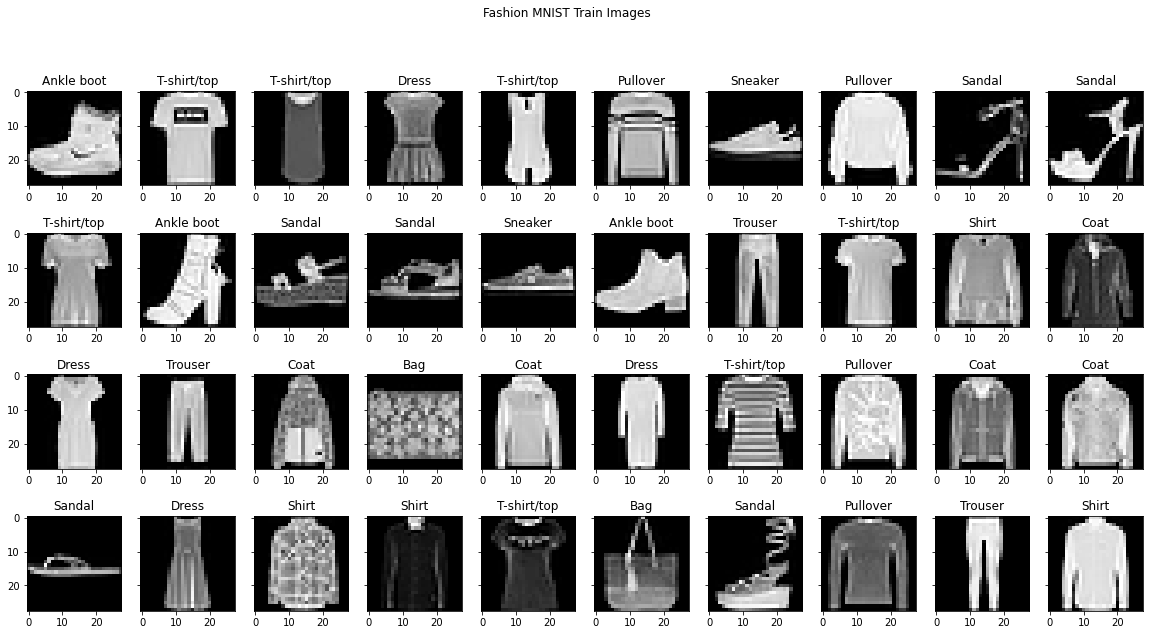

In [ ]:
# Visualising the dataset
labeldic = {}
labeldic[0] = 'T-shirt/top'
labeldic[1] = 'Trouser'
labeldic[2] = 'Pullover'
labeldic[3] = 'Dress'
labeldic[4] = 'Coat'
labeldic[5] = 'Sandal'
labeldic[6] = 'Shirt'
labeldic[7] = 'Sneaker'
labeldic[8] = 'Bag'
labeldic[9] = 'Ankle boot'
print('Lenth of Trainset = {}'.format(len(trainset)))
print('Lenth of Testset = {}'.format(len(testset)))
print('Dimensions of each image = ({},{})'.format(trainset[0][0].shape[1],trainset[0][0].shape[2]))
fig, axs = plt.subplots(4, 10, sharey=True, figsize = (20,10))
for i in range(40):
  axs[i//10,i%10].imshow(trainset[i][0].squeeze(), cmap = 'gray')
  axs[i//10,i%10].set_title('{}'.format(labeldic[trainset[i][1]]))
plt.suptitle('Fashion MNIST Train Images')
plt.show()

In [ ]:
def idx2onehot(idx, n=10, rep = 10):
    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    return torch.repeat_interleave(onehot,rep,1)
# Generator and Discriminator Architecures

# We have given the Generator architecture for the first task
# Note the significance of the input size of the first layer and the output size of the last layer
# The generator takes a noise vector of size (B,100), where B is the batch size and produces a 28x28 image
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(256, 128, kernel_size = (5,5), stride = (1,1), padding = (2,2)),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.ConvTranspose2d(128, 64, kernel_size = (4,4), stride = (2,2), padding = (1,1)),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2,inplace=True),
        nn.ConvTranspose2d(64, 1, kernel_size = (4,4), stride = (2,2), padding = (1,1)),
        nn.Tanh()
    )
    self.linear = nn.Sequential(
        nn.Linear(200,7*7*256,bias=True),
        nn.LeakyReLU(0.2,inplace=True),
    )

  # forward pass
  def forward(self, x, labels):
    x = torch.cat((x,idx2onehot(labels.to(device),n=10,rep=10)),dim = -1)
    return self.conv(self.linear(x).reshape(-1,256,7,7))


# Now define a suitable Discriminator (use 3-4 Linear Layers, the final layer should be sigmoid)
# The discriminator takes a flattened 28x28 images and produces a single logit as it's score.
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    ## TODO ##
    self.conv = nn.Sequential(
        nn.Conv2d(11, 64, kernel_size=(5,5), stride=(2,2), padding=(2,2)),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Dropout(0.3),
        nn.Conv2d(64, 128, kernel_size=(5,5), stride=(2,2), padding=(2,2)),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Dropout(0.3),
    )
    self.linear = nn.Sequential(
        nn.Linear(6272,1,bias=True),
        nn.Sigmoid(),
    )
    ## TODO ##

  # forward pass
  def forward(self, x, labels):
    encod = torch.zeros(x.shape[0],10,x.shape[2],x.shape[3]).to(device)+idx2onehot(labels.to(device),n=10,rep=1).reshape(x.shape[0],10,1,1)
    x = torch.cat((x,encod), dim = 1)
    return self.linear(self.conv(x).reshape(x.shape[0],-1))

In [ ]:
# Create the models
G = Generator().to(device)
D = Discriminator().to(device)

In [ ]:
# Define the Optimizer
optimizer_g = optim.Adam(G.parameters(), lr = 3e-5)
optimizer_d = optim.Adam(D.parameters(), lr = 3e-5)

In [ ]:
# Define the Washerstein Loss functions
lamda = 10
def get_WLoss_generator(fake_images, labels):
  ## TODO ##
  
  ## TODO ##
  return gen_loss

def get_WLoss_discriminator(fake_images, true_images, labels):
  ## TODO ##
  
  ## TODO ##
  return (gradient_penalty*lamda + critic_loss).mean()

def get_gradient_regularisation(fake_images, true_images, labels):
  ## TODO ##
  
  ## TODO ##

from torch.autograd import grad
def get_grad(fake_images, true_images, labels):
  epsilon = torch.FloatTensor(np.random.uniform(size=(fake_images.shape[0], 1, 1, 1))).to(device)
  xbar = epsilon*true_images + (1-epsilon)*fake_images
  xbar.requires_grad_()
  lipschitz_grad = grad(
      outputs=D(xbar, labels).sum(), 
      inputs=xbar,
      create_graph=True, 
      retain_graph = True)[0]
  return lipschitz_grad.view(xbar.shape[0], -1)


In [ ]:
# Train Function
# returns the total loss for the epoch
def train(epoch):
  loss_acc_g = 0
  loss_acc_d = 0
  
  for i, (images, labels) in tqdm(enumerate(trainloader), desc = "Training for epoch {}".format(epoch), total=len(trainloader)):
    ## Discriminator Training
    ## TODO ##
    optimizer_d.zero_grad()
    # Discriminator training on real images
    true_images = images.to(device)
    # Discriminator training on fake images
    fake_images = 
    loss_d = 
    loss_d.backward()    
    optimizer_d.step()
    ## TODO ##

    if i % 5 == 0:
      # Generator training
      ## TODO ##
      optimizer_g.zero_grad()
      fake_images = 
      loss_g = 

      loss_g.backward()
      optimizer_g.step()
      ## TODO ##
      loss_acc_g += loss_g.item()
    loss_acc_d += loss_d.item()

  return (loss_acc_g/(i/5)+loss_acc_d/i), loss_acc_g/(i/5), loss_acc_d/i


In [ ]:
load_pretrained = False

In [ ]:
if load_pretrained:
  solution_id = '1doxxbSfp0dEUkDMGcjIpXSKPHrpHfUlU'
# Functions to save and load checkpoints
# Enter the path on your shared drive where the checkpoint is to be saved

## TODO ##
path_to_checkpoint = './checkpoints'
if not os.path.isdir(path_to_checkpoint):
  os.mkdir(path_to_checkpoint)
## TODO ##
if load_pretrained:
  os.system('gdown --id {} -O checkpoints/checkpoint_cwgan.pth'.format(solution_id))
import os
def save_checkpoint(e):
  if not os.path.isdir(path_to_checkpoint):
    os.mkdir(path_to_checkpoint)
  torch.save({'e':e,'gen': G.state_dict(), 'disc': D.state_dict(), 'optim_d': optimizer_d.state_dict(), 'optim_g':optimizer_g.state_dict()}, os.path.join(path_to_checkpoint, 'checkpoint_cwgan.pth'))
def load_checkpoint():
  if not os.path.isfile(os.path.join(path_to_checkpoint, 'checkpoint_cwgan.pth')):
    return -1
  dic = torch.load(os.path.join(path_to_checkpoint, 'checkpoint_cwgan.pth'))
  G.load_state_dict(dic['gen'])
  D.load_state_dict(dic['disc'])
  optimizer_d.load_state_dict(dic['optim_d'])
  optimizer_g.load_state_dict(dic['optim_g'])
  return dic['e']

In [ ]:
# The generate functions are defined here
def generate(n, ci):
  ## TODO ##
  
  ## TODO ##

In [ ]:
## TODO ##
NUM_EPOCHS = 300
## TODO ##
losses_g = []
losses_d = []

# Resume training
offset = load_checkpoint()
if os.path.exists('images'):
  if offset == -1:
    os.system('rm -rf images')
    os.mkdir('images')
else:
  os.mkdir('images')


for e in range(NUM_EPOCHS):
  if e <= offset:
    continue
  loss, loss_g, loss_d = train(e)
  losses_g.append(loss_g)
  losses_d.append(loss_d)
  G.eval()
  li = torch.randint(0,10,(1,))[0].item()
  g_output = generate(1, li)[0]
  G.train()
  plt.imshow(g_output.reshape(28,28), cmap = 'gray')
  plt.title('Category: {}'.format(labeldic[li]))
  plt.savefig('./images/{}.png'.format(e))
  print('loss_g = {}, loss_d = {}\n'.format(loss_g,loss_d))
  save_checkpoint(e)

Training for epoch 0:  89%|████████▊ | 416/469 [01:37<00:12,  4.08it/s]

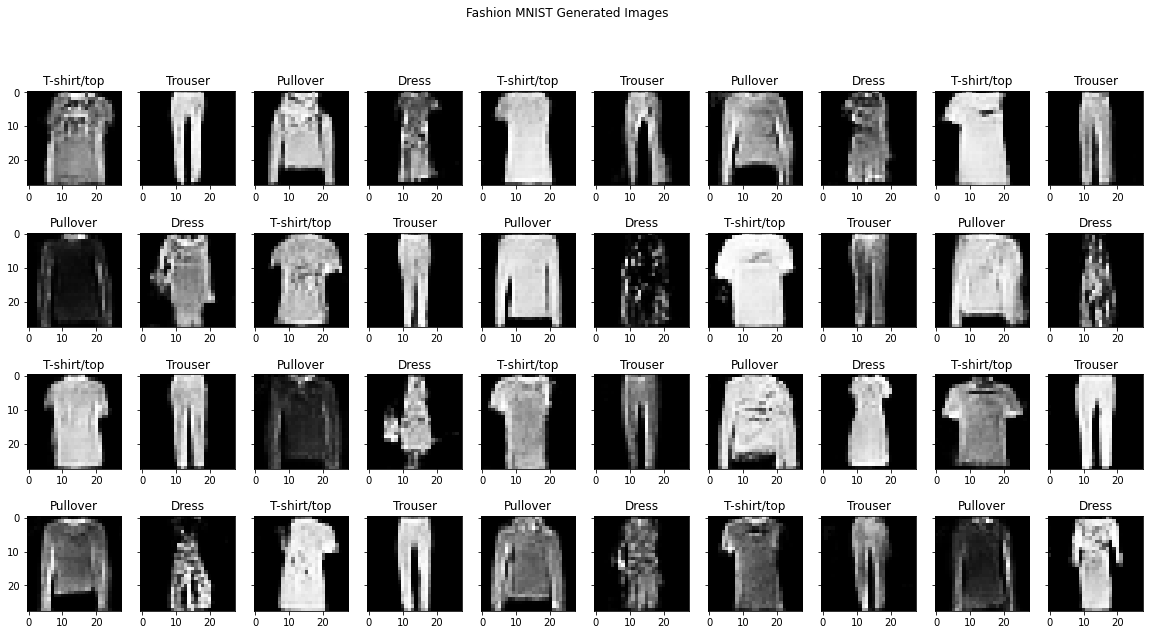

In [ ]:
## Test script
load_checkpoint()
with torch.no_grad():
  G.eval()
  fig, axs = plt.subplots(4, 10, sharey=True, figsize = (20,10))
  for i in range(40):
    fake_image = generate(1,i%4)[0]
    axs[i//10, i%10].imshow(fake_image.reshape(28,28), cmap = 'gray')
    axs[i//10, i%10].set_title('{}'.format(labeldic[i%4]))
  plt.suptitle('Fashion MNIST Generated Images')
  plt.show()